In [4]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 8.5 MB/s eta 0:00:00


In [5]:
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from fairlearn.metrics import (
    MetricFrame,
    count,
    equalized_odds_difference,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import EqualizedOdds, ExponentiatedGradient

warnings.simplefilter("ignore")

rand_seed = 1234
np.random.seed(rand_seed)

In [6]:
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = (
    pd.read_excel(io=data_url, header=1)
    .drop(columns=["ID"])
    .rename(columns={"PAY_0": "PAY_1", "default payment next month": "default"})
)

dataset.shape

(30000, 24)

In [7]:
dataset

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3,1,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [8]:
categorical_features = ["SEX", "EDUCATION", "MARRIAGE"]
for col_name in categorical_features:
    dataset[col_name] = dataset[col_name].astype("category")

Y, A = dataset.loc[:, "default"], dataset.loc[:, "SEX"]
X = pd.get_dummies(dataset.drop(columns=["default", "SEX"]))
A_str = A.map({1: "male", 2: "female"})
A_str.value_counts(normalize=True)

SEX
female    0.603733
male      0.396267
Name: proportion, dtype: float64

In [9]:
A

0        2
1        2
2        2
3        2
4        1
        ..
29995    1
29996    1
29997    1
29998    1
29999    1
Name: SEX, Length: 30000, dtype: category
Categories (2, int64): [1, 2]

In [10]:
Y.value_counts(normalize=True)

default
0    0.7788
1    0.2212
Name: proportion, dtype: float64

In [11]:
X

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,False,True,False,False,False,False,False,True,False,False
1,120000,26,-1,2,0,0,0,2,2682,1725,...,False,True,False,False,False,False,False,False,True,False
2,90000,34,0,0,0,0,0,0,29239,14027,...,False,True,False,False,False,False,False,False,True,False
3,50000,37,0,0,0,0,0,0,46990,48233,...,False,True,False,False,False,False,False,True,False,False
4,50000,57,-1,0,-1,0,0,0,8617,5670,...,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,39,0,0,0,0,0,0,188948,192815,...,False,False,True,False,False,False,False,True,False,False
29996,150000,43,-1,-1,-1,-1,0,0,1683,1828,...,False,False,True,False,False,False,False,False,True,False
29997,30000,37,4,3,2,-1,0,0,3565,3356,...,False,True,False,False,False,False,False,False,True,False
29998,80000,41,1,-1,0,0,0,-1,-1645,78379,...,False,False,True,False,False,False,False,True,False,False


In [12]:
X.loc[:, "Interest"] = np.random.normal(loc=2 * Y, scale=A)
X[["Interest"]]

,Interest
0,2.942870
1,-0.381951
2,2.865414
3,-0.625304
4,-0.720589
...,...
29995,1.758204
29996,0.002537
29997,3.246178
29998,2.618972


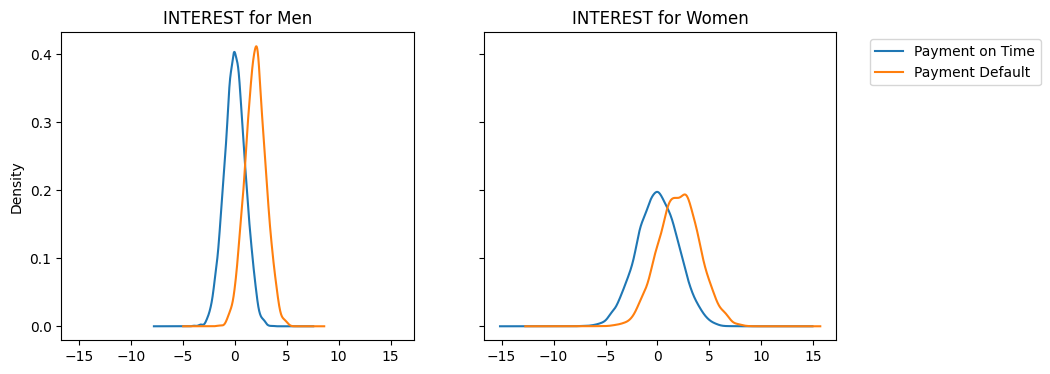

In [13]:
fig, (ax_1, ax_2) = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)
X["Interest"][(A == 1) & (Y == 0)].plot(
    kind="kde", label="Payment on Time", ax=ax_1, title="INTEREST for Men"
)
X["Interest"][(A == 1) & (Y == 1)].plot(kind="kde", label="Payment Default", ax=ax_1)
X["Interest"][(A == 2) & (Y == 0)].plot(
    kind="kde",
    label="Payment on Time",
    ax=ax_2,
    legend=True,
    title="INTEREST for Women",
)
X["Interest"][(A == 2) & (Y == 1)].plot(
    kind="kde", label="Payment Default", ax=ax_2, legend=True
).legend(bbox_to_anchor=(1.6, 1))

# Training an initial model
train a fairness-unaware model

In [14]:
def resample_training_data(X_train, Y_train, A_train):
    """Down-sample the majority class in the training dataset to produce a
    balanced dataset with a 50/50 split in the predictive labels.

    Parameters:
    X_train: The training split of the features
    Y_train: The training split of the target labels
    A_train: The training split of the sensitive features

    Returns:
    Tuple of X_train, Y_train, A_train where each dataset has been re-balanced.
    """
    negative_ids = Y_train[Y_train == 0].index
    positive_ids = Y_train[Y_train == 1].index
    balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids)))

    X_train = X_train.loc[balanced_ids, :]
    Y_train = Y_train.loc[balanced_ids]
    A_train = A_train.loc[balanced_ids]
    return X_train, Y_train, A_train

In [15]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, Y, A_str, test_size=0.35, stratify=Y
)

X_train, y_train, A_train = resample_training_data(X_train, y_train, A_train)

In [16]:
lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.03,
    "num_leaves": 10,
    "max_depth": 3,
    "random_state": rand_seed,
    "n_jobs": 1,
    "verbose": -1,
}

estimator = Pipeline(
    steps=[
        ("preprocessing", StandardScaler()),
        ("classifier", lgb.LGBMClassifier(**lgb_params)),
    ]
)

estimator.fit(X_train, y_train)


Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc',
                                n_jobs=1, num_leaves=10, objective='binary',
                                random_state=1234, verbose=-1))])